# Distribution

Copyright (C) 2022 John Penuel.  Published under the terms of the GNU General Public License version 3 or later.  See https://www.gnu.org/licenses/.

# Solving A System of Linear Equations on the D-Wave QPU

Many problems in optimization, differential equations and other subjects can be reduced to solving a system of linear equations.  Generically, we want to solve the following system of linear equations:
\begin{align}
    Ax & = b
\end{align}

* $A$ is an $m \times n$ matrix of real numbers.
* $a_{ij}$ is the component of $A$ in row $i$, column $j$
* $a_i$ is the $i^\text{th}$ row of matrix $A$.  For notation, we treat it as an $n \times 1$ column vector.
* $b$ is a $m \times 1$ vector.
* $x$ is an $n \times 1$ vector that we wish to solve for.
   - Since we are dealing with D-Wave specifically, $x$ is a binary vector in $\{ 0, 1 \}^n$.

Because $x$ is a binary vector, this is considered 0-1 Integer Programming and is an NP-Complete problem as shown in original Karp-21 problems.  I.e., there is no known polynomial time algorithm to find a solution or prove that a solution does not exist.

Consider one linear equation at a time:

\begin{align}
    a^{\top}_i x  & = b_i, & i = 0,...,m-1
\end{align}

D-Wave computers can solve Quadratic Unconstrained Binary Optimization (QUBO) problems.  We attempt to solve the system of equations by minimizing some QUBO objective function.  For our function, we will *penalize* each equation by $\lambda \gt 0$ if the equation is not satisfied.  

Given a solution to the equation $\bar{x}$, then $(a^{\top}_i\bar{x} - b_i) = 0$.  If $\bar{x}$ is also solution to *all* of the equations, then $(a^{\top}_i\bar{x} - b_i) = 0$ for all $i = 0, ..., m-1$.  Similarly, the *squared* quantity $(a^{\top}_i x - b_i)^2$ is zero when the equation is satisfied and positive otherwise.  The squared quantity is never negative.  So we craft our quadratic objective function as:
\begin{align}
    f(x) & = \sum_i \lambda_i (a^{\top}_i x - b)^2
\end{align}
Note that there are no constraints on $x$ other than it's a binary vector.  Therefore we have a QUBO.  If we can find a solution $\bar{x} \in \{ 0, 1 \}^n$ that satisfies $A\bar{x}=b$, then $f(\bar{x}) = 0$, and $f(x)$ is minimized.


We need to do a bit more algebra to make this fit cleanly into the D-Wave API.  Specifically we want to rearrange terms so that we have a objective function of the form
\begin{align}
    f(x) & = x^{\top}Qx + L^{\top}x
\end{align}
where $Q$ is an $n \times n$ matrix of coefficients for the quadratic terms and $L$ is an $n \times 1$ vector of coefficients for the linear terms.


\begin{align}
    f(x) & = \sum_i \lambda_i (a^{\top}_i x - b)^2\\
         & = \sum_i \lambda_i \left( (a^{\top}_i x)^2 - 2(a^{\top}_ix)b_i + b_i^2 \right) \\
         & = \sum_i \lambda_i \left( (a^{\top}_i x)(a^{\top}_i x) - 2(a^{\top}_ix)b_i + b_i^2 \right) \\
         & = \sum_i \lambda_i \left( (x^{\top}a_i)(a^{\top}_i x) + (-2b_ia^{\top}_i)x + b_i^2 \right) \\
         & = \sum_i \lambda_i \left( x^{\top}(a_ia^{\top}_i)x + (-2b_ia^{\top}_i)x + b_i^2 \right) \\
         & = x^{\top} \left( \sum_i \lambda_i (a_ia^{\top}_i) \right) x + \left( -2 \sum_i \lambda_i b_i a^{\top}_i \right) x + \left( \sum_i \lambda_i b_i^2 \right)& \text{ rearrange}\\
         & = \sum_i \lambda_i \left( x^{\top}(a_ia^{\top}_i)x + (-2b_ia^{\top}_i)x \right) & \text{remove constant term}\\

         & = x^{\top}Qx + L^{\top}x
\end{align}
Note that $a_ia^{\top}_i$ is a symmetric $n \times n$ matrix.  So $Q = \left( \sum_i \lambda_i (a_ia^{\top}_i) \right)$ and $L = \left( -2 \sum_i \lambda_i b_i a^{\top}_i \right)$.  We removed the constant term $\left( \sum_i \lambda_i b_i^2 \right)$ since it will not have an impact on the optimization.  However, now our objective function $f(x)$ may be negative.  There will still be some $\bar{x}$ that *minimizes* $f(x)$ and we will find it.  Before we removed the constant term the minimum of $f(x)$ was zero.  After we removed the constant term the minimum of $f(x)$ will be $-\sum_i \lambda_i b_i^2 $.  The same $\bar{x}$ where $f(\bar{x}) = -\sum_i \lambda_i b_i^2 $ will be the solution to the original set of equations.


We can take the concept further and consolidate $Q$ and $L$.  Since $x_i \in \{ 0, 1\}$, then $x_i^2 = x_i$.  So we can rewrite the $L$-term as:
\begin{align}
    L^{\top}x   & = L^{\top}x \\
                & = \text{diag}(L)x \\
                & = x^{\top}\text{diag}(L)x \\
\end{align}
Where $\text{diag}(L)$ is the projection of the $(n \times 1)$ vector $L$ into the diagonal elements of an $(n\times n)$ matrix with zeros on the off-diagonal elements.  This is also a quadratic term,  So we can rearrange and consolidate:
\begin{align}
    f(x)  & = x^{\top}Qx + x^{\top}Lx\\
          & = x^{\top}(Q + L)x\\
          & = x^{\top}Q'x   & \text{define } Q' = Q + L\\
\end{align}


The D-Wave system will translate a matrix $Q'$ as follows. The diagonal elements will be qubit biases and the off-diagonal elements will be qubit coupling strength.  Our $Q'$ matrix we have constructed is symmetric.  Element $a_{ij}$ is equal to element $a_{ji}$.  So the qubit coupling strength between qubit $i$ and qubit $j$ is $a_{ij}$... or is it $a_{ji}$?  Qubit coupling is not directional, so it doesn't make sense to have a separate $a_{ij}$ and $a_{ji}$, even if they are equal.  D-Wave's documentation implies that the input matrix should be upper triangular, not symmetric.  It's not clear what behavior may result if we feed D-Wave system an input that has nonzero in the lower left elements.  So we will convert our symmetric $Q'$ matrix to an upper triangular matrix as follows.  The result is equivalent because multiplication commutes.

\begin{align}
    f(x)  & = x^{\top}Q'x\\
          & = \sum_{i} a_{ii} x_{i}^2 + \sum_{i,j : i \lt j} a_{ij}x_i x_j + \sum_{j,i : j \gt i} a_{ji}x_j x_i\\
          & = \sum_{i} a_{ii} x_{i}^2 + \sum_{i,j : i \lt j} 2 a_{ij}x_i x_j  & \text{ because } a_{ij} = a_{ji}\\
          & = \sum_{i} a_{ii} x_{i}^2 + \sum_{i,j : i \lt j} 2 a_{ij}x_i x_j  + \sum_{j,i : j \gt i} 0 a_{ji} x_j x_i & \text{ reintroduced 0-term for clarity } \\
          & = x^{\top} \begin{bmatrix} 
                \left[ a_{ii} \right]              &         &  \left[ 2a_{ij} \right]_{i \lt j} \\
                                                   &  \ddots &                                   \\
                \left[ 0 a_{ji} \right]_{j \gt i}  &         & \left[ a_{ii} \right]   \end{bmatrix} x \\
          & = x^{\top}Q''x & \text{ define Q''}\\
\end{align}

So we can convert our symmetric $Q'$ matrix into an upper triangular matrix $Q''$ as shown above.  We will construct and use $Q''$ for the following calculations.  In the code below, we let our notation slip and simply call it $Q$.

# An example


Consider the following system of $m=2$ linear equations and $n=6$ binary variables:
\begin{align}
    5x_0 + 6x_1 + 2x_2 + 1x_3 + 3x_4 + 4x_5 &= 10  & \text{  equation 0}\\
    2x_0 + 3x_1 + 2x_2 + 4x_3 + 3x_4 + 6x_5 &=  7  & \text{  equation 1}
\end{align}
By inspection or enumeration, we can show that each equation has multiple solutions, but there is only one solution $\bar{x} = (1,0,1,0,1,0)$ that satisfied *both* equations.


We use the penalty terms $\lambda_0, \lambda_1$ for each respective equation. 

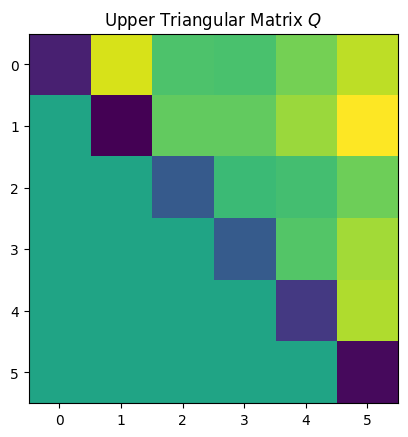



Constant:  14900.0
The solution will have minimum 'energy' of  -14900.0


In [1]:
# Formulate Problem

import pprint
import numpy as np
import matplotlib.pyplot as plt


m = 2
n = 6

A = np.array([[5,6,2,1,3,4],
    [2,3,2,4,3,6]])

b = [10, 7]

lambda_penalty = [1e2, 1e2]

# build interim Q-matrix
Q_matrix = np.zeros((n,n))
a_i = np.zeros((n,1))
for i in range(m):
    a_i = np.array([A[i,:]]).T
    Q_matrix = Q_matrix + lambda_penalty[i]*np.matmul(a_i,a_i.T)

# build interim L-matrix
L_matrix = np.zeros((n,n))
L_temp = np.zeros((n,n))
for i in range(m):
    a_i = np.array([A[i,:]]).T
    for j in range(n):
        L_temp[j][j] = b[i]*a_i[j]
    L_matrix = L_matrix + (-2.0)*lambda_penalty[i]*L_temp


# still interim... symmetric but not upper triangular yet.
Q_matrix = Q_matrix + L_matrix


# D-Wave input is a dictionary, not a numpy array.
Q = {}

# diagonal elements
for i in range(n):
    Q[(i,i)] = Q_matrix[i][i]

# off-diagonal elements
# This constructs the upper-triangular matrix (dictionary) as shown above.
for i in range(n):
    for j in range(i+1,n):
        Q[(i,j)] = 2*Q_matrix[i][j]
        Q_matrix[i][j] = 2*Q_matrix[i][j]
        Q_matrix[j][i] = 0

plt.imshow(Q_matrix)
plt.title("Upper Triangular Matrix $Q$")
plt.show()

# pprint.pprint(Q)

constant = 0
for i in range(m):
    constant += lambda_penalty[i]*b[i]**2

print("\n\nConstant: ",constant)
print("The solution will have minimum 'energy' of ",-constant)



# the solution is known for our trivial example.
# x_soln = [1,0,1,0,1,0]
# fx_soln = np.matmul(x_soln,np.matmul(Q_matrix,x_soln))
# print(fx_soln)



In [2]:
from dwave.system.samplers import DWaveSampler

# Create the DWaveSampler object.  
# Note that the "~/dwave_config" file contains the developer's API token
sampler = DWaveSampler(config_file="~/dwave_config",
                        solver="Advantage_system6.1")

print(sampler.solver.id)

Advantage_system6.1


In [3]:
from dwave.system.composites import EmbeddingComposite

# Create the Embedding Composite object from our Sampler.
# This will heuristically map our original i,j indexes to 
# actual qubit indexes or chains of logical qubit so 
# we don't have to do that mapping (or reverse mapping) manually.
# It should calculate a new embedding every time we sample the problem.

sampler = EmbeddingComposite(sampler)

print(sampler.child.solver.id)

Advantage_system6.1


In [4]:
# Task the QPU and get results

chain_strength = 1e6
num_reads = 50

response = sampler.sample_qubo(Q,
                    chain_strength=chain_strength,
                    num_reads=num_reads,
                    label="solving_linear_equations")

In [5]:
# Interpret Results

pprint.pprint(response)

SampleSet(rec.array([([1, 0, 1, 0, 1, 0], -14900., 2, 0.),
           ([0, 1, 1, 0, 1, 0], -14700., 2, 0.),
           ([1, 0, 0, 0, 0, 1], -14700., 1, 0.),
           ([0, 1, 0, 0, 1, 0], -14700., 1, 0.),
           ([0, 1, 0, 0, 0, 1], -14500., 1, 0.),
           ([1, 0, 1, 1, 0, 0], -14400., 1, 0.),
           ([0, 1, 1, 1, 0, 0], -14400., 1, 0.),
           ([1, 1, 0, 0, 0, 0], -14400., 1, 0.),
           ([0, 1, 1, 0, 0, 0], -14100., 1, 0.),
           ([1, 0, 0, 0, 1, 0], -14100., 1, 0.),
           ([1, 1, 1, 0, 0, 0], -14000., 2, 0.),
           ([1, 1, 0, 0, 1, 0], -13200., 2, 0.),
           ([0, 0, 1, 1, 1, 0], -12900., 2, 0.),
           ([1, 0, 0, 0, 1, 1], -12900., 2, 0.),
           ([0, 1, 1, 0, 0, 1], -12900., 1, 0.),
           ([0, 0, 1, 0, 1, 0], -12000., 3, 0.),
           ([0, 1, 0, 0, 0, 0], -11700., 2, 0.),
           ([0, 0, 0, 1, 0, 1], -11500., 1, 0.),
           ([0, 0, 1, 1, 0, 1], -11500., 1, 0.),
           ([0, 0, 0, 0, 0, 1], -11200., 1, 0.),
          

# Conclusions and Future Work

We find the minimum 'energy' solution of $\bar{x} = (1,0,1,0,1,0)$ with the predicted energy.  This also solves our system of linear equations.

Quantum Annealing is a heuristic and is not guaranteed to provide an optimal solution.  In this case it worked, but it also settled on other solutions with higher energy.  A statistically significant number of 'runs' need to be executed to increase the probability that the minimum energy solution is found.  As with all heuristics, the performance depends on the problem instance data, size and other structure.

Future would shall include the following:

* Determine what restrictions (if any) on the properties of the matrix $Q$ are required to effectively run the instance on the D-Wave QPU.  
* Our system of linear equations may translate into a $Q$ matrix that is not sparse.  This translates to additional qubit connectivity requirements.  The actual hardware doesn't have the ability to connect arbitrary qubits together.  This implies that the embedding function needs to create a lot of artificial qubits by chaining others together with an appropriate chain strength.  Therefore, we need to characterize how this method will scale for the D-Wave topology.
